# Building Theoretical, Synthetic Spectrum Normalization

We need to be able to convert between detector units (which might be electrons/s) to physical units of star flux, i.e. $\mathrm{\frac{erg}{\mathring{A}\,s\,cm^{2}}}$. To do this we need to know how to normalize the spectrum. We need a normalization function with units of  $\mathrm{\frac{cm^{2}\,e^{-}}{erg}}$.

We have the "sensitivity" of the detector which is defined as 

$S(\lambda) = \frac{\pi r_{mirror}^2 \cdot T({\lambda}) \cdot Q({\lambda})}{E(\lambda)}$

i.e. 

- The area of the telescope based on its mirror radius $r_{mirror}$
- The throughput of the telescope $T$
- The quantum efficiency of the detector $Q$
- And the energy of photons $E$

The SED of the star multiplied by this sensitivity will give us the response Pandora will measure.

This is useful, however

1. In flight we actually do not know the as flown $T$ or $Q$, or even really $r_{mirror}$ to perfect accuracy.
2. There may be unknown factors contributing to sensitivity (e.g. detector effects)
3. This sensitivity is also convolved with our PRF across the spectrum.

As such, while we have a guess of the sensitivity, we need an **as flown spectrum normalization** function. This will be an empirical function. 

To create our first guess at this function, we'll use our current best estimates for all these factors and model a spectrum.

In flight, we will build this correction from data, but it should look similar to the correction we build here in terms of magnitude and units. 

In [87]:
import pandoraref as pr
import pandorasat as ps
import pandorapsf as pp
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

nirda = ps.NIRDetector()
p = pp.PSF.from_name("nirda_fallback", transpose=True)
ts = pp.TraceScene(np.asarray([[300, 40]]), psf=p, wavelength=p.trace_wavelength[::1][:-1])
pix = (np.arange(400) - 300) * u.pixel

To build this we're going to use the Vega spectrum that is included in our tools

In [88]:
wav, sed = ps.phoenix.load_vega()
k = (wav.to(u.micron).value > 0.6) & (wav.to(u.micron).value < 2)
sens = nirda.sensitivity(wav)

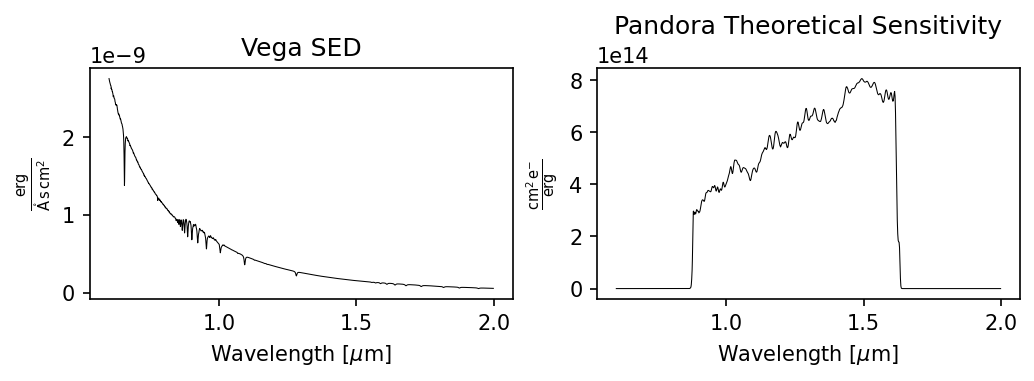

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2), dpi=150)
ax[0].plot(wav[k].to(u.micron), sed[k], color='k', lw=0.5)
ax[1].plot(wav[k].to(u.micron), sens[k], color='k', lw=0.5)
ax[0].set(xlabel='Wavelength [$\mu$m]', title='Vega SED', ylabel=sed.unit.to_string('latex'))
ax[1].set(xlabel='Wavelength [$\mu$m]', title='Pandora Theoretical Sensitivity', ylabel=sens.unit.to_string('latex'));

These are the theoretical inputs and do not account for the resolution of the detector and the shape of the PRF.

We can use the `pandorapsf.TraceScene` object to integrate the SED of Vega and see the spectra we will retrieve

In [90]:
ar = ts.model(sed[k], wavelength=wav[k])[0]
spectrum_per_pix = np.sum(ar.to(u.electron/u.pixel/u.second), axis=1)
w = nirda.reference.get_wavelength_position(pix)
dw = np.gradient(w, pix)

spectrum_per_wav = spectrum_per_pix / dw

/Users/chedges/Library/Caches/pypoetry/virtualenvs/pandorapsf-Fwaspdv0-py3.9/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/chedges/Library/Caches/pypoetry/virtualenvs/pandorapsf-Fwaspdv0-py3.9/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


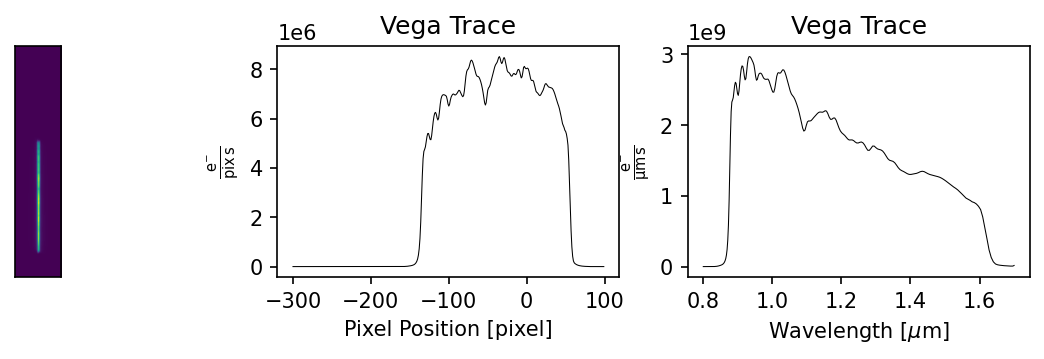

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(10, 2), dpi=150)
ax[0].imshow(ar.value)
ax[0].set(xticks=[], yticks=[])
ax[1].plot(pix, spectrum_per_pix, color='k', lw=0.5)
ax[2].plot(w, spectrum_per_wav, color='k', lw=0.5)
ax[1].set(xlabel='Pixel Position [pixel]', title='Vega Trace', ylabel=spectrum_per_pix.unit.to_string('latex'))
ax[2].set(xlabel='Wavelength [$\mu$m]', title='Vega Trace', ylabel=spectrum_per_wav.unit.to_string('latex'));

We can calculate the edges and center of the spectrum

In [92]:
j = (pix.value > -160) & (pix.value < -120)
grad = np.gradient(spectrum_per_pix[j].value, pix[j].value)
l = np.argmax(grad)
a, b, c = np.polyfit(pix[j][l-1:l+2], np.log(np.abs(grad[l-1:l+2])), 2)
sigma = np.sqrt(-1/(2*a))
left_edge = b * sigma**2
j = (pix.value > 40) & (pix.value < 80)
grad = np.gradient(spectrum_per_pix[j].value, pix[j].value)
l = np.argmin(grad)
a, b, c = np.polyfit(pix[j][l-1:l+2], np.log(np.abs(grad[l-1:l+2])), 2)
sigma = np.sqrt(-1/(2*a))
right_edge = b * sigma**2
center = np.mean([left_edge, right_edge], axis=0)

In [93]:
left_edge, right_edge, center

(-134.94627195926776, 55.64024365768335, -39.6530141507922)

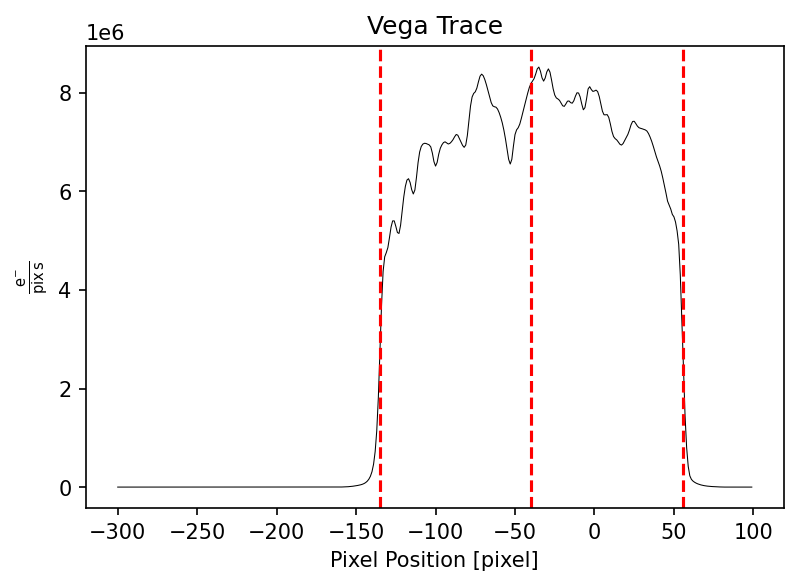

In [94]:
fig, ax = plt.subplots(dpi=150, figsize=(6, 4))
ax.plot(pix, spectrum_per_pix, color='k', lw=0.5)
[ax.axvline(c, c='r', ls='--') for c in [left_edge, right_edge, center]]
ax.set(xlabel='Pixel Position [pixel]', title='Vega Trace', ylabel=spectrum_per_pix.unit.to_string('latex'));

This looks good. Now we need to calculate how to normalize the spectrum.

We **can not** simply divide out the sensitivity because we need to account for the PRF of the instrument. We now have to integrate with an SED of 1, in order to find just the sensitivity.

In the figure below, red is the input sensitivity and black is the extracted sensitivity.

In [95]:
ar = ts.model(sed[k]**0 * sed.unit, wavelength=wav[k])[0]/sed.unit
sens_per_pix = np.sum(ar, axis=1).to((u.cm**2 * u.electron * u.AA)/(u.erg*u.pixel))
w = nirda.reference.get_wavelength_position(pix)
dw = np.gradient(w, pix)

sens_per_wav = (sens_per_pix / dw).to((u.cm**2 * u.electron)/(u.erg))

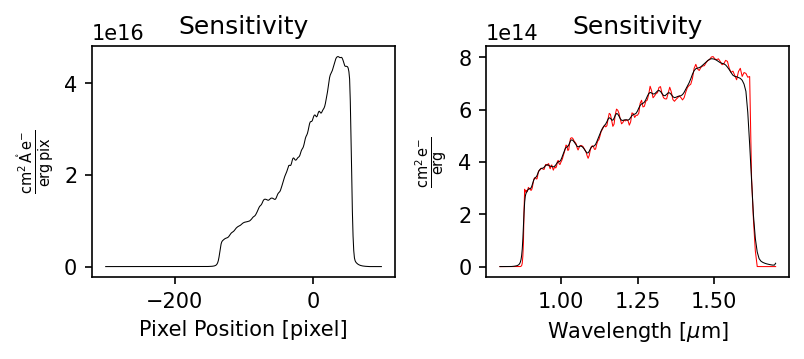

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=150)
ax[0].plot(pix, sens_per_pix, color='k', lw=0.5)
ax[1].plot(w, nirda.sensitivity(w), color='r', lw=0.5)
ax[1].plot(w, sens_per_wav, color='k', lw=0.5)
ax[0].set(xlabel='Pixel Position [pixel]', title='Sensitivity', ylabel=sens_per_pix.unit.to_string('latex'))
ax[1].set(xlabel='Wavelength [$\mu$m]', title='Sensitivity', ylabel=sens_per_wav.unit.to_string('latex'));
plt.subplots_adjust(wspace=0.3)

Now we can use this normalization to correct our synthetic Pandora spectrum.

If we have a spectrum in wavelength units we use the wavelength sensitivity

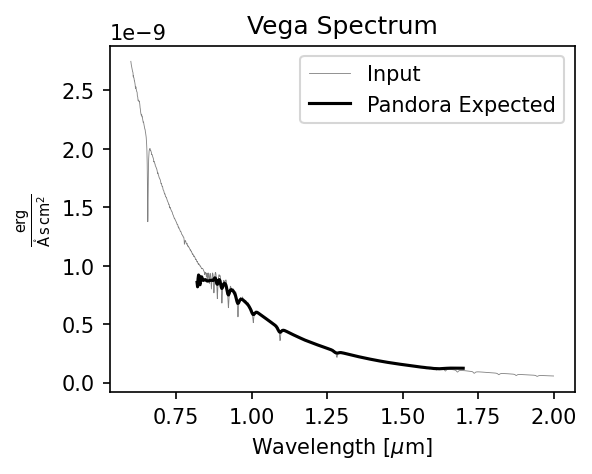

In [97]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ax.plot(wav[k].to(u.micron), sed[k], color='grey', lw=0.4, label='Input')
ax.plot(w, (spectrum_per_wav/sens_per_wav).to(u.erg/(u.AA*u.s*u.cm**2)), color='k', label='Pandora Expected')
ax.set(xlabel='Wavelength [$\mu$m]', title='Vega Spectrum', ylabel=(u.erg/(u.AA*u.s*u.cm**2)).to_string('latex'));
ax.legend()

If we have a spectrum in pixels, we use the pixel sensitivity. This corrects for the pile-up of photons at one side of the spectrum when recorded on the detector.

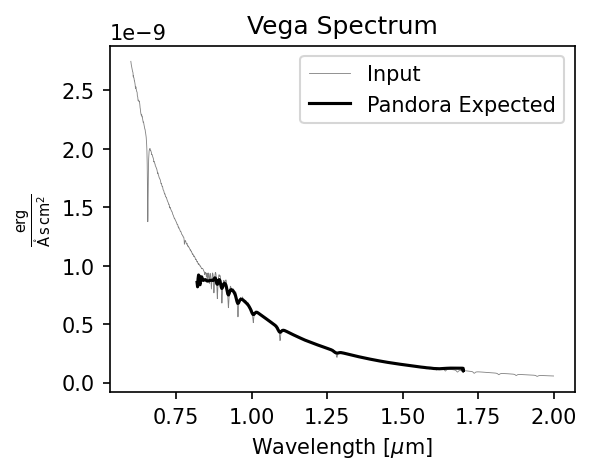

In [98]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ax.plot(wav[k].to(u.micron), sed[k], color='grey', lw=0.4, label='Input')
ax.plot(w, (spectrum_per_pix/sens_per_pix).to(u.erg/(u.AA*u.s*u.cm**2)), color='k', label='Pandora Expected')
ax.set(xlabel='Wavelength [$\mu$m]', title='Vega Spectrum', ylabel=(u.erg/(u.AA*u.s*u.cm**2)).to_string('latex'));
ax.legend()

Now we have to package this spectrum normalization into a reference product.

In [106]:
from astropy.io import fits
from astropy.time import Time
def create_nirda_spectrum_normalization(pix, wav, sens_per_pix, sens_per_wav, le, re, center, version):
    """Creates a wavelength normalization file."""

    hdr0 = fits.Header(
        [
            # Remember to update this keyword if you are running this with real data!
            ("SIMDATA", True, "simulated data"),
            ("SCIDATA", False, "science data"),
            ("TELESCOP", "NASA Pandora", "telescope"),
            ("CAMERAID", "H2rgCam", "ID of camera used in acquisition"),
            ("INSTRMNT", "NIRDA", "instrument"),
            ("CREATOR", "Pandora DPC", "creator of this product"),
            ("VERSION", version, "creator software version"),
            ("DATE", Time.now().isot, "creation date"),
        ]
    )

    hdr1 = fits.Header(
        [
            ("EXTNAME", "SOLUTION", "name of extension"),
            ("L_EDGE", le, "Left edge of the trace in pixel position"),
            ("R_EDGE", re, "Right edge of the trace in pixel position"),
            ("CENTER", center, "Center of the trace in pixel position"),
        ]
    )
    sens_per_wav[~np.isfinite(sens_per_wav.value)] = 0 * sens_per_wav.unit
    k = (sens_per_wav.value != 0) & np.isfinite(sens_per_wav.value)
    k = np.arange(np.max([0, np.where(k)[0][0] - 2]), np.min([len(k), np.where(k)[0][-1] + 3]), 1)
    tab = fits.TableHDU.from_columns(
        [
            fits.Column(name="Pixel", format="E", array=pix.value[k], unit=pix.unit.to_string()),
            fits.Column(name="Wavelength", format="E", array=wav.value[k], unit=wav.unit.to_string()),
            fits.Column(name="Sensitivity Per Pixel", format="E", array=sens_per_pix.value[k], unit=sens_per_pix.unit.to_string()),
            fits.Column(name="Sensitivity Per Wavelength", format="E", array=sens_per_wav.value[k], unit=sens_per_wav.unit.to_string()),
        ],
        header=hdr1,
    )

    hdulist = fits.HDUList([fits.PrimaryHDU(header=hdr0), tab])
    return hdulist

In [107]:
hdulist = create_nirda_spectrum_normalization(pix=pix - center*u.pixel, wav=w, sens_per_wav=sens_per_wav, sens_per_pix=sens_per_pix, le=left_edge - center, re=right_edge - center, center=center - center, version='dummy')

Now we can save this as a reference product to `pandora-ref`. Remember, in flight this will be replaced by an as measured spectrum normalization, rather than a synthetic one. You will use this product to check the as measured version is similar, qualitatively. It should have the same units, and a similar magnitude.

In [108]:
hdulist.writeto("/Users/chedges/Pandora/repos/pandora-ref/src/pandoraref/data/nirda/spectrum_normalization.fits", overwrite=True)